
# Load table

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
import pandas as pd
import datetime as dt
import numpy as np
import sys

pd.options.display.float_format = '${:,.2f}'.format

try:
    from google.colab import auth
    from google.colab import drive
    import gspread
    from oauth2client.client import GoogleCredentials
    
    drive.mount('/content/gdrive')

    auth.authenticate_user()
    gc = gspread.authorize(GoogleCredentials.get_application_default())
        
    !rm -rf github
    !mkdir github
    !cd github && git clone https://github.com/dr315/Finances.git
    !ls /content/github/Finances/
    sys.path.append('/content/github/Finances')

    !pip install yfinance
    !pip install pdfplumber
    
    from FinanceTools import *
    from OrdersReader import *
    ReadOrders('/content/gdrive/MyDrive/Investing/Notas_Clear', 'operations.csv')

    worksheet = gc.open('operations').sheet1
    # get_all_values gives a list of rows.
    rows = worksheet.get_all_values()
    df = pd.DataFrame.from_records(rows[1:], coerce_float=True)
    
except:
    from FinanceTools import *
    from OrdersReader import *
    
    root = 'd:/'
    ReadOrders('d:/Investing/Notas_Clear', 'operations.csv')
    df = pd.read_csv(root + '/Investing/operations.csv')    

    # df = pd.read_csv(/operations2021.tsv', delimiter='\t', thousands=',', decimal='.')

# display(df)


Starting pages
Getting tickers names...Done
Pages done
Tickers merging...Done


## Formating table

In [2]:
 
df = df.iloc[:, :7]
df.columns=['Codigo','Data', 'Valor', 'Quantidade', 'Tipo', 'Categoria', 'Despesas']
 
#Removing the stored dividends in order to donwload again from internet
df = df[df.Tipo != 'Proventos']

if(df['Valor'].apply(type).eq(str).any()): 
    df['Valor'] = df['Valor'].str.replace(',', '')
    df['Valor'] = pd.to_numeric(df['Valor'], errors='coerce')
    df['Quantidade'] = pd.to_numeric(df['Quantidade'], errors='coerce')
    df['Despesas'] = pd.to_numeric(df['Despesas'], errors='coerce')
 
#drop empty lines
df=df[df['Data'].astype(bool)].dropna()
# df

if(df['Data'].apply(type).eq(str).any()): 
    df.Data = df.Data.str.replace('-','/')
    df['Data'] = pd.to_datetime(df.Data, format='%Y/%m/%d')
df['Year'] = pd.DatetimeIndex(df['Data']).year
df['Month'] = pd.DatetimeIndex(df['Data']).month_name()

#Sort the table by date and Type and reset index numeration
df.sort_values(by=['Data', 'Tipo'], ascending=[True, True], inplace=True)
df.reset_index(drop=True, inplace=True)

#turn all sell amount negative
df.loc[df.Tipo == 'Venda', ['Quantidade']] *= -1

#Get the oldest order date
startDate = df.iloc[0]['Data']

#Calc Operation Value
df['Total'] = df.Valor * df.Quantidade + df.Despesas


In [3]:
df['acum_qty'] = 0
#Get the complete list of assets
stocks = np.sort(df.Codigo.unique()).tolist()
# Clear operation costs befere 2019
# df.Despesas.update(df.apply(clear2018Cost, axis=1))


## PriceReader

In [4]:
# import concurrent.futures
import time
import threading
start_time = time.time()

prcReader = PriceReader(stocks, startDate)
splReader = SplitsReader(df)
divReader = DividendReader(df)
# divReader = YfinanceReader(df)

def threadExecutor(obj):
    obj.load()

threadList = []
threadList.append(threading.Thread(target=threadExecutor, args=(prcReader,)))
threadList.append(threading.Thread(target=threadExecutor, args=(divReader,)))
threadList.append(threading.Thread(target=threadExecutor, args=(splReader,)))

for td in threadList:
    td.start()

for td in threadList:
    td.join()

print("--- %s seconds ---" % (time.time() - start_time))

h:\Git\Finances\FinanceTools.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  self.df.columns = self.df.columns.str.replace('\.SA','')
--- 27.61728858947754 seconds ---


In [5]:
dfBak = df

## Accumulator

In [6]:

df=dfBak
df['acum_qty'] = 0
df['PM'] = 0

for paper in stocks:
  paperTable = df[(df.Codigo == paper)]
  fromDate = paperTable.iloc[0]['Data']  
  toDate = dt.datetime.today().strftime('%Y-%m-%d')

  divTable = divReader.getPeriod(paper,fromDate, toDate)
  divTable['Quantidade'] = 0
  divTable['Tipo'] = 'Proventos'
  divTable['Categoria'] = paperTable.iloc[0]['Categoria']
  divTable['Despesas'] = 0
  divTable['Year'] = pd.DatetimeIndex(divTable.index).year
  divTable['Month'] = pd.DatetimeIndex(divTable.index).month_name()
  divTable['Total'] = 0
  divTable['acum_qty'] = 0
  df = df.append(divTable.reset_index())

  splitTable = splReader.getPeriod(paper,fromDate, toDate)
  splitTable['Valor'] = 0
  splitTable['Tipo'] = 'Split'
  splitTable['Categoria'] = paperTable.iloc[0]['Categoria']
  splitTable['Despesas'] = 0
  splitTable['Year'] = pd.DatetimeIndex(splitTable.index).year
  splitTable['Month'] = pd.DatetimeIndex(splitTable.index).month_name()
  splitTable['Total'] = 0
  splitTable['acum_qty'] = 0
  df = df.append(splitTable.reset_index())

df.sort_values(['Data', 'Tipo'], inplace=True)

#Create obj
ta = TableAccumulator()
#Calc the average price and rename the columns names
df=df.groupby(['Codigo']).apply(ta.ByGroup).reset_index(drop=True).dropna()
df.sort_values(['Data', 'Tipo'], inplace=True)

In [7]:
# df[df.Codigo.str.contains('CIEL3')]

# Realized Profit


## Processing

In [8]:

profit = Profit()
df.sort_values(by=['Data', 'Tipo'], ascending=[True, True], inplace=True)
df.reset_index(drop=True)
df=df.groupby(['Codigo', 'Data']).apply(profit.Trade).reset_index()
df.drop('index', axis=1, inplace=True)


## View

In [9]:
rl = df[df.Tipo == 'Venda'][['Data',	'Codigo', 'Categoria', 'Profit',	'DayTrade']]
rl['Data'] = rl['Data'].apply(lambda x: x.strftime('%Y-%m-%d'))
rl.loc['Total', 'Profit'] = rl['Profit'].sum()
rl.fillna(' ', inplace=True)
rl.style.applymap(color_negative_red, subset=['Profit']).format( {'Profit': 'R$ {:,.2f}', 'DayTrade': '{}'})


,Data,Codigo,Categoria,Profit,DayTrade
10,2018-03-20,KLBN11,Stock,R$ 10.28,0.0
16,2018-04-02,BMEB4,Stock,R$ 2.87,0.0
19,2018-04-04,MOVI3,Stock,R$ 32.70,0.0
20,2018-04-04,MOVI3,Stock,R$ 32.70,0.0
21,2018-04-05,ECOR3,Stock,R$ 111.21,0.0
27,2018-04-20,PETR4,Stock,R$ 35.90,0.0
39,2018-05-09,MFII11,FII,R$ 72.94,0.0
40,2018-05-09,MFII11,FII,R$ 20.15,0.0
43,2018-05-15,XPML11,FII,R$ -2.40,0.0
44,2018-05-15,XPML11,FII,R$ -2.40,0.0


# Investiment Portifolio


In [10]:
Portifolio(prcReader,df).show()

,PM,Cotacao,Quantidade,Custo,Valor,Proventos,Rentabilidade,Lucro,%R,%R+d
Ativo,,,,,,,,,,
ABEV3,R$ 11.15,R$ 15.36,500,"R$ 5,574.73","R$ 7,680.00",R$ 214.17,"R$ 2,105.27","R$ 2,319.44",37.76%,41.61%
BBDC3,R$ 22.10,R$ 22.16,200,"R$ 4,419.33","R$ 4,432.00",R$ 12.14,R$ 12.67,R$ 24.81,0.29%,0.56%
CIEL3,R$ 7.05,R$ 3.81,3451,"R$ 24,346.40","R$ 13,148.31","R$ 1,199.13","R$ -11,198.09","R$ -9,998.97",-45.99%,-41.07%
COGN3,R$ 7.87,R$ 4.11,1050,"R$ 8,261.20","R$ 4,315.50",R$ 133.65,"R$ -3,945.70","R$ -3,812.05",-47.76%,-46.14%
EGIE3,R$ 41.51,R$ 41.51,100,"R$ 4,151.32","R$ 4,151.00",R$ 315.63,R$ -0.32,R$ 315.31,-0.01%,7.60%
EZTC3,R$ 36.01,R$ 33.49,100,"R$ 3,601.12","R$ 3,349.00",R$ 29.41,R$ -252.12,R$ -222.71,-7.00%,-6.18%
FAMB11B,R$ 1480.50,"R$ 1,239.66",5,"R$ 7,402.48","R$ 6,198.30",R$ 9.16,"R$ -1,204.18","R$ -1,195.02",-16.27%,-16.14%
FLRY3,R$ 25.40,R$ 26.39,100,"R$ 2,539.80","R$ 2,639.00",R$ 141.38,R$ 99.20,R$ 240.58,3.91%,9.47%
GRND3,R$ 7.22,R$ 8.35,1274,"R$ 9,192.85","R$ 10,637.90",R$ 341.36,"R$ 1,445.05","R$ 1,786.41",15.72%,19.43%


# Performance Blueprint

In [11]:

p = PerformanceBlueprint(prcReader, df, dt.datetime.today().strftime('%m-%d-%Y'))
PerformanceViewer(p.calc()).show()


,Value R$,%C
Item,,
Equity,"167,779.77",84.6%
Cost,"198,217.57",100.0%
Expenses,116.75,0.1%
Paper profit,"-30,437.80",-15.4%
Realized profit,"17,117.74",8.6%
Dividends,"19,206.64",9.7%
Total Profit,"5,886.58",3.0%


# Taxation


In [12]:
profitLossDF = df.loc[df['Profit'] != 0]
tx = Taxation(profitLossDF)

## FII

### Swing Trade

In [13]:
tx.Process('FII')
display(tx.swingTradeTable)

Profit   AcumLoss  Dutiable    Tax
Year Month                                           
2018 May          $126.03      $0.00   $126.03 $25.21
     June           $1.46      $0.00     $1.46  $0.29
     September $-5,073.30 $-5,073.30     $0.00  $0.00
2019 April        $806.90 $-4,266.39     $0.00  $0.00
     July       $4,411.54      $0.00   $145.15 $29.03

### Day Trade

In [14]:
try:
  display(tx.dayTradeTable)
except:
  print('Not avalilable')

Not avalilable


## Stocks


### Swing Trade

In [15]:
tx.Process('Stock')
display(tx.swingTradeTable)

Profit  AcumLoss  Dutiable   Tax
Year Month                                       
2018 March       $10.28         0    $10.28 $0.00
     April    $1,646.87         0 $1,646.87 $0.00
     November $1,211.12         0 $1,211.12 $0.00
2020 January  $9,818.77         0 $9,818.77 $0.00
     June     $3,872.46         0 $3,872.46 $0.00
     July     $1,698.08         0 $1,698.08 $0.00

### Day Trade

In [16]:
try:
  display(tx.dayTradeTable)
except:
  print('Not avalilable')

,,Profit,AcumLoss,Dutiable,Tax
Year,Month,,,,
2019,November,$19.00,0,$19.00,$3.80


# Plots

In [17]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
 
stock_picker = widgets.Dropdown(options=stocks, value=stocks[0])
stock_picker

Dropdown(options=('ABEV3', 'BBDC3', 'BBFI11B', 'BMEB4', 'CIEL3', 'COGN3', 'ECOR3', 'EGIE3', 'EZTC3', 'FAMB11B'…

## Average price Evolution

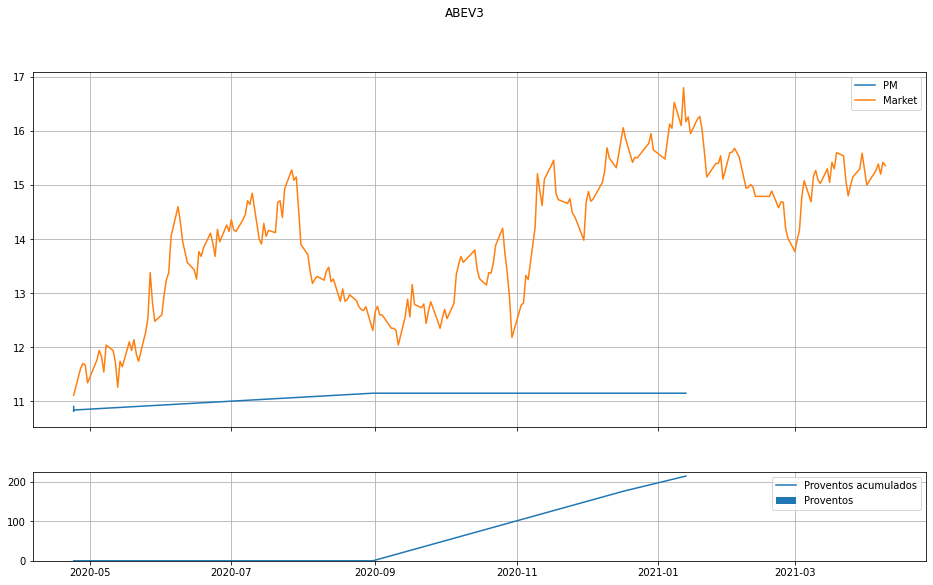

In [18]:
stock = stock_picker.value

fig, axs = plt.subplots(2, 1, figsize=(16, 9), sharex=True, gridspec_kw={'height_ratios': [4, 1]})
pickedDF = df.loc[df.Codigo == stock]

div = pickedDF.loc[pickedDF.Tipo == 'Proventos']

prc = prcReader.getHistory([stock], pickedDF.iloc[0]['Data'].strftime('%d-%m-%y'))
axs[0].plot(pickedDF.Data, pickedDF.PM, label='PM')
axs[0].plot(prc.index, prc[stock], label='Market')
axs[0].grid(True, which='both')
axs[0].legend()

axs[1].plot(pickedDF.Data, pickedDF.acumProv, label='Proventos acumulados')
axs[1].bar(div.Data, div.Valor, label='Proventos')
axs[1].grid(True, which='both')
axs[1].legend()

fig.suptitle(stock)
plt.show()

## Historical profitability

In [19]:
startTimePicker = widgets.Dropdown(options=['All', '12 months'], value='12 months')
startTimePicker

Dropdown(index=1, options=('All', '12 months'), value='12 months')

In [25]:
startPlot = startDate
frequency = 'SM'
if (startTimePicker.value == "12 months"):
  startPlot = (dt.datetime.today() - pd.Timedelta(365, unit='d')).strftime('%Y-%m-%d')
  frequency = 'W'

monthList = pd.date_range(start=startPlot, end=dt.datetime.today(), freq=frequency).format(formatter=lambda x: x.strftime('%Y-%m-%d'))
monthList.append(dt.datetime.today().strftime('%Y-%m-%d'))
performanceList = []
for i, month in enumerate(monthList):
  p = PerformanceBlueprint(prcReader, df, month)
  p.calc()
  performanceList.append([p.date, p.equity, p.cost, p.realizedProfit, p.div, p.paperProfit, p.profit, p.profitRate, p.expense, p.ibov, p.sp500])

histProfDF = pd.DataFrame(performanceList, columns=['Date', 'Equity', 'Cost', 'Profit', 'Div', 'paperProfit', 'TotalProfit', '%Profit', 'Expense', '%IBOV', '%SP500'])
histProfDF['Date'] = pd.to_datetime(histProfDF.Date, format='%Y/%m/%d')
# if (startTimePicker.value == "12 months"):
# histProfDF['%IBOV']   = histProfDF['%IBOV'] - histProfDF.iloc[0]['%IBOV']
# histProfDF['%SP500']  = histProfDF['%SP500'] - histProfDF.iloc[0]['%SP500']
# histProfDF['%Profit'] = histProfDF['%Profit'] - histProfDF.iloc[0]['%Profit']
# histProfDF

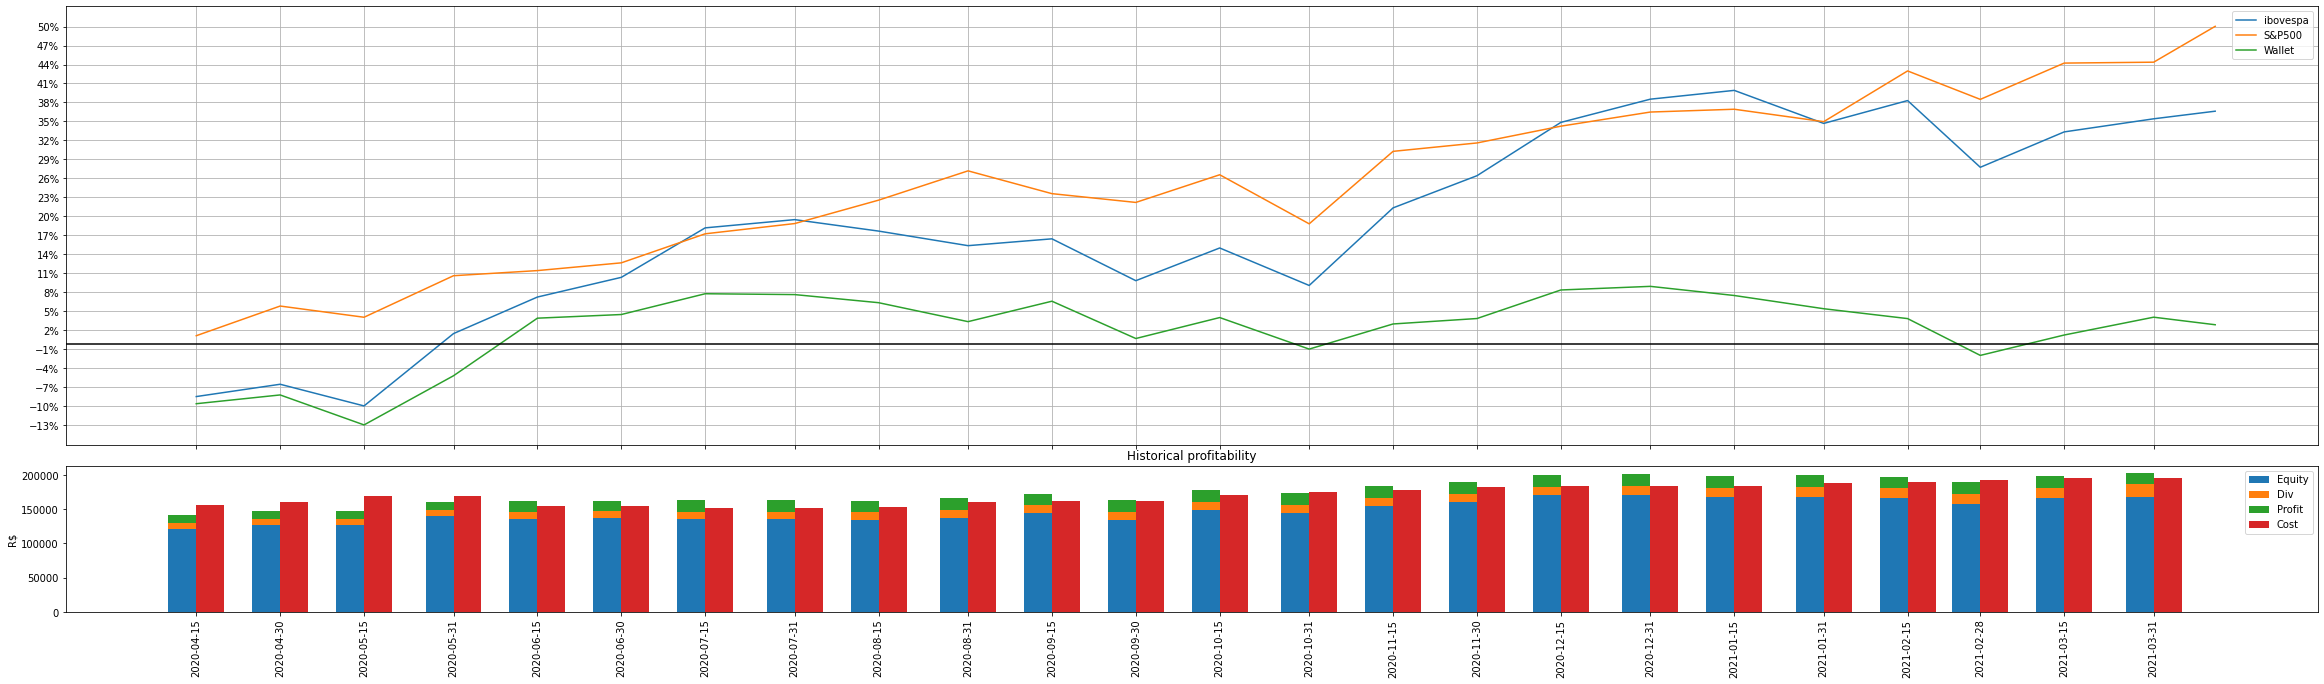

In [26]:
import matplotlib.ticker as mtick

width = 5       # the width of the bars: can also be len(x) sequence
shift = pd.Timedelta(width/2, unit='d')
fig, ax = plt.subplots(2, 1, figsize=(32, 9), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
fig.tight_layout()

ax[0].plot(histProfDF.Date, histProfDF['%IBOV'], label='ibovespa')
ax[0].plot(histProfDF.Date, histProfDF['%SP500'], label='S&P500')
ax[0].plot(histProfDF.Date, histProfDF['%Profit'], label='Wallet')

minTick = min(histProfDF['%IBOV'].min(), histProfDF['%SP500'].min(), histProfDF['%Profit'].min())
maxTick = max(histProfDF['%IBOV'].max(), histProfDF['%SP500'].max(), histProfDF['%Profit'].max())

ax[0].set_yticks(np.arange(minTick, maxTick, 0.03))
ax[0].axhline(y=0, color='k')
ax[0].grid(True, which='both')
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax[0].legend()

barsDf = histProfDF[:-1]
# ax[1].grid(True, which='both')
ax[1].bar(barsDf.Date - shift, barsDf['Equity'], width, label='Equity')
ax[1].bar(barsDf.Date - shift, barsDf['Div']   , width, bottom=barsDf['Equity'], label='Div')
ax[1].bar(barsDf.Date - shift, barsDf['Profit'], width, bottom=barsDf['Div'] + barsDf['Equity'], label='Profit')
ax[1].bar(barsDf.Date + shift, barsDf['Cost']  , width, label='Cost')
ax[1].legend()
ax[1].set_ylabel('R$')

plt.xticks(barsDf['Date'], rotation=90)
plt.title('Historical profitability')
plt.show()

In [27]:
data = dt.datetime.today().strftime('%Y-%m-%d')
PerformanceViewer(histProfDF, data).show()


,Value R$,%C
Item,,
Equity,"167,779.77",84.6%
Cost,"198,217.57",100.0%
Expenses,116.75,0.1%
Paper profit,"-30,437.80",-15.4%
Realized profit,"17,117.74",8.6%
Dividends,"19,206.64",9.7%
Total Profit,"5,886.58",3.0%


# Dividends by month

In [28]:
m = int(dt.datetime.today().strftime("%m"))
y = int(dt.datetime.today().strftime("%Y"))
m=3

divTable = divReader.df
prov = df[df['Tipo'] == 'Proventos']

divTable = divTable.reset_index()
divTable = divTable[(divTable['Data de Pagamento'].dt.month == m) & (divTable['Data de Pagamento'].dt.year == y)]

divTable= pd.merge(divTable, prov, how='inner', on=['Data', 'Codigo', 'Valor'])

divTable = divTable[['Data de Pagamento', 'Codigo','Total']]
divTable.columns = ['Data', 'Ativo', 'R$']
# divTable = divTable.groupby(['Ativo', 'Data'])['R$'].sum().reset_index()
# display(divTable)
divTable.sort_values('Data', inplace=True)
divTable['Data'] = divTable['Data'].apply(lambda x: x.strftime('%Y-%m-%d'))
divTable.loc['Total', 'R$'] = divTable['R$'].sum()
divTable.fillna(' ', inplace=True)
divTable


,Data,Ativo,R$
1,2021-03-01,ITUB3,$3.00
2,2021-03-01,BBDC3,$2.92
0,2021-03-05,FLRY3,$19.95
3,2021-03-08,BBDC3,$3.37
8,2021-03-08,SPTW11,$20.24
9,2021-03-08,SPTW11,$12.65
4,2021-03-12,ITUB3,$8.60
5,2021-03-12,ITUB3,$19.28
6,2021-03-12,GTWR11,$8.04
7,2021-03-12,MXRF11,$16.00


In [29]:
pvt = prov.pivot_table(index='Year', columns='Month', values='Total', margins=True, margins_name='Total', aggfunc='sum', fill_value=0)
sorted_m = sorted(pvt.columns[:-1], key=lambda month: dt.datetime.strptime(month, "%B"))
sorted_m.append(pvt.columns[-1])
pvt.reindex(sorted_m, axis=1)

Month,January,February,March,April,May,June,July,August,September,October,November,December,Total
Year,,,,,,,,,,,,,
2018,$0.00,$0.00,$141.96,$263.39,$298.14,$290.60,$388.06,$429.80,$543.65,$367.89,$535.02,$752.53,"$4,011.03"
2019,$333.12,$638.72,$471.04,$286.79,$260.51,$397.89,$182.20,$204.12,$266.94,$214.16,$305.92,$625.90,"$4,187.31"
2020,$251.61,$423.80,$379.96,$255.87,$307.26,$362.43,$345.54,$984.42,$263.06,$441.89,$638.66,"$1,106.71","$5,761.22"
2021,$284.04,$250.80,"$4,675.31",$36.92,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,"$5,247.08"
Total,$868.78,"$1,313.32","$5,668.27",$842.97,$865.92,"$1,050.92",$915.80,"$1,618.34","$1,073.65","$1,023.94","$1,479.60","$2,485.14","$19,206.64"
